# Parkinsons Telemonitoring Prediction

##  Problem Definition
This is a project to identify a supervised learning problem and perform EDA and model analysis.
In this case, the problem we will be exploring is **regression analysis**. 

We will use different features about a person to predict their unified Parkinson's disease rating scale (UPDRS). This analysis could be particularly useful because tracking Parkinson's disease (PD) symptom progression often uses unified Parkinson's disease rating scale (UPDRS). Getting the rating scale requires the patient's presence in clinic, and time-consuming physical examinations by trained medical staff. Symptom monitoring is costly and logistically inconvenient for patient and clinical staff alike. 

In a statement,

> Given clinical parameters about a patient, can we predict their unified Parkinson's disease rating scale?

### Dataset Information
The data contains a range of biomedial voice measurements from 42 people with early-stage Parkinson's disease. The dataset is provided by:

Athanasios Tsanas, Max A. Little, Patrick E. McSharry, Lorraine O. Ramig (2009),<br>
'Accurate telemonitoring of Parkinson’s disease progression by non-invasive speech tests',<br>
IEEE Transactions on Biomedical Engineering.

### Data Dictionary
Columns in the table contain subject number, subject age, subject gender, time interval from baseline recruitment date, motor UPDRS, total UPDRS, and 16 biomedical voice measures. Each row corresponds to one of 5,875 voice recording from these individuals. The main aim of the data is to predict the total UPDRS scores ('total_UPDRS') from the 16 voice measures.

The data is in ASCII CSV format. The rows of the CSV file contain an instance corresponding to one voice recording. There are around 200 recordings per patient, the subject number of the patient is identified in the first column. 

Additional information about the variables can be found at https://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring.

In [54]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [55]:
# Fetch dataset 
parkinsons_telemonitoring = fetch_ucirepo(id=189) 
  
# Break data into X and y (as pandas dataframes) 
X = parkinsons_telemonitoring.data.features.copy()
y = parkinsons_telemonitoring.data.targets["total_UPDRS"].copy() 
  
# Get variable information 
print(parkinsons_telemonitoring.variables)


             name     role        type demographic  \
0        subject#       ID     Integer        None   
1             age  Feature     Integer         Age   
2       test_time  Feature  Continuous        None   
3       Jitter(%)  Feature  Continuous        None   
4     Jitter(Abs)  Feature  Continuous        None   
5      Jitter:RAP  Feature  Continuous        None   
6     Jitter:PPQ5  Feature  Continuous        None   
7      Jitter:DDP  Feature  Continuous        None   
8         Shimmer  Feature  Continuous        None   
9     Shimmer(dB)  Feature  Continuous        None   
10   Shimmer:APQ3  Feature  Continuous        None   
11   Shimmer:APQ5  Feature  Continuous        None   
12  Shimmer:APQ11  Feature  Continuous        None   
13    Shimmer:DDA  Feature  Continuous        None   
14            NHR  Feature  Continuous        None   
15            HNR  Feature  Continuous        None   
16           RPDE  Feature  Continuous        None   
17            DFA  Feature  

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data
I will view the data and determine if it needs cleaning. After that, I'll determine which variables to use for testing and get some understanding for how they are related to the target variable.

In [56]:
X.head()

,age,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,sex
0,72,5.6431,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006,0
1,72,12.6660,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810,0
2,72,19.6810,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014,0
3,72,25.6470,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277,0
4,72,33.6420,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361,0


In [57]:
X.describe()

,age,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,sex
count,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000
mean,64.804936,92.863722,0.006154,0.000044,0.002987,0.003277,0.008962,0.034035,0.310960,0.017156,0.020144,0.027481,0.051467,0.032120,21.679495,0.541473,0.653240,0.219589,0.317787
std,8.821524,53.445602,0.005624,0.000036,0.003124,0.003732,0.009371,0.025835,0.230254,0.013237,0.016664,0.019986,0.039711,0.059692,4.291096,0.100986,0.070902,0.091498,0.465656
min,36.000000,-4.262500,0.000830,0.000002,0.000330,0.000430,0.000980,0.003060,0.026000,0.001610,0.001940,0.002490,0.004840,0.000286,1.659000,0.151020,0.514040,0.021983,0.000000
25%,58.000000,46.847500,0.003580,0.000022,0.001580,0.001820,0.004730,0.019120,0.175000,0.009280,0.010790,0.015665,0.027830,0.010955,19.406000,0.469785,0.596180,0.156340,0.000000
50%,65.000000,91.523000,0.004900,0.000034,0.002250,0.002490,0.006750,0.027510,0.253000,0.013700,0.015940,0.022710,0.041110,0.018448,21.920000,0.542250,0.643600,0.205500,0.000000
75%,72.000000,138.445000,0.006800,0.000053,0.003290,0.003460,0.009870,0.039750,0.365000,0.020575,0.023755,0.032715,0.061735,0.031463,24.444000,0.614045,0.711335,0.264490,1.000000
max,85.000000,215.490000,0.099990,0.000446,0.057540,0.069560,0.172630,0.268630,2.107000,0.162670,0.167020,0.275460,0.488020,0.748260,37.875000,0.966080,0.865600,0.731730,1.000000


Now that we've taken a peak at the data, lets see if there are any missing values, duplicates, or dtype misidenfifications, and fix them if they are present. Let's also see if any of the data looks like outliers.

In [58]:
# Do data validation
missing_vals = X.isnull().sum()
print(f'Missing values:\n{missing_vals}')
duplicates = X.duplicated().sum()
print(f'Duplicates:\n{duplicates}')
# Check the data types of the features
print(X.dtypes)
# Sex should be changed to categorical
X['sex'] = X['sex'].astype('category')

# Check for outliers
z_scores = np.abs(stats.zscore(X.select_dtypes(include=[np.number])))
outliers = (z_scores > 3).sum(axis=0)
print(f'Outliers detected:\n{outliers}')

Missing values:
age              0
test_time        0
Jitter(%)        0
Jitter(Abs)      0
Jitter:RAP       0
Jitter:PPQ5      0
Jitter:DDP       0
Shimmer          0
Shimmer(dB)      0
Shimmer:APQ3     0
Shimmer:APQ5     0
Shimmer:APQ11    0
Shimmer:DDA      0
NHR              0
HNR              0
RPDE             0
DFA              0
PPE              0
sex              0
dtype: int64
Duplicates:
0
age                int64
test_time        float64
Jitter(%)        float64
Jitter(Abs)      float64
Jitter:RAP       float64
Jitter:PPQ5      float64
Jitter:DDP       float64
Shimmer          float64
Shimmer(dB)      float64
Shimmer:APQ3     float64
Shimmer:APQ5     float64
Shimmer:APQ11    float64
Shimmer:DDA      float64
NHR              float64
HNR              float64
RPDE             float64
DFA              float64
PPE              float64
sex                int64
dtype: object
Outliers detected:
age              101
test_time          0
Jitter(%)        107
Jitter(Abs)      115
Jitt

There are outliers that have been identified. However, given the source of the data, I don't think that they actually need to be removed. This gives us some insight into which models may be acceptable: a linear regression model may have some problems with the data that has been called an outlier, so we may need to use a tree-method. 
From here, we will evalaute which features we should use in the model.

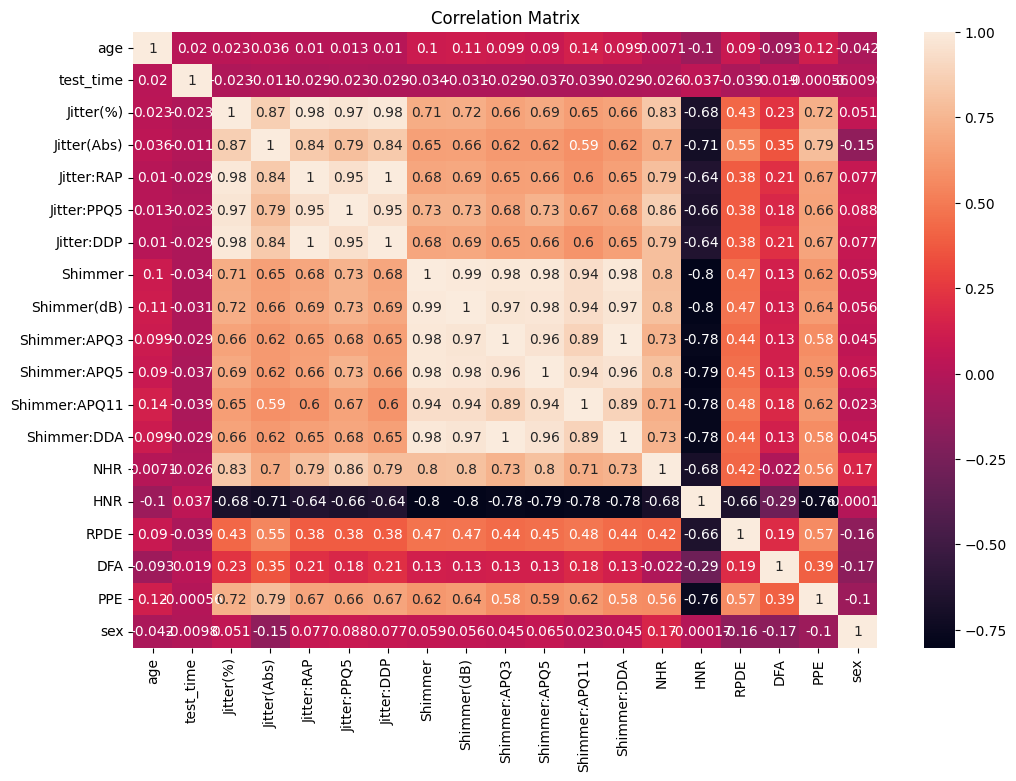

In [59]:
# Calculate the correlation matrix
corr_matrix = X.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

The features are definitely suffering from being correlated, which isn't surprising considering that there are six different versions of the same feature (Jitter, Shimmer). 0.8 seems like a reasonable threshold for the correlation matrix, so let's drop pairs above that threshold.

In [60]:
# Remove the highly correlated variables
def get_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_corrs(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

# List top n pairs of highly correlated variables
print("Top absolute correlations")
print(get_top_corrs(X, 10))

# Threshold for identifying highly correlated features
threshold = 0.8

# Find pairs of features with correlation above the threshold
corr_pairs = corr_matrix.abs().unstack()
high_corr_pairs = corr_pairs[(corr_pairs > threshold) & (corr_pairs < 1)]

# Drop one of each pair of highly correlated features
features_to_drop = set()
for index in high_corr_pairs.index:
    if high_corr_pairs[index] > threshold:
        features_to_drop.add(index[0])  # Drop the first feature in the pair

# Update the features dataset
X_reduced = X.drop(columns=features_to_drop)

print(f"Features to drop due to high collinearity: {features_to_drop}")

Top absolute correlations
Shimmer:APQ3  Shimmer:DDA     1.000000
Jitter:RAP    Jitter:DDP      1.000000
Shimmer       Shimmer(dB)     0.992334
              Shimmer:APQ5    0.984904
Jitter(%)     Jitter:DDP      0.984184
              Jitter:RAP      0.984181
Shimmer       Shimmer:APQ3    0.979828
              Shimmer:DDA     0.979827
Shimmer(dB)   Shimmer:APQ5    0.976373
Jitter(%)     Jitter:PPQ5     0.968214
dtype: float64
Features to drop due to high collinearity: {'Jitter:DDP', 'Shimmer:DDA', 'Shimmer', 'Jitter(%)', 'Jitter:RAP', 'Shimmer:APQ3', 'Shimmer(dB)', 'Shimmer:APQ11', 'HNR', 'Jitter(Abs)', 'Jitter:PPQ5', 'NHR', 'Shimmer:APQ5'}


Let's visualize the remaining features in terms of Y.

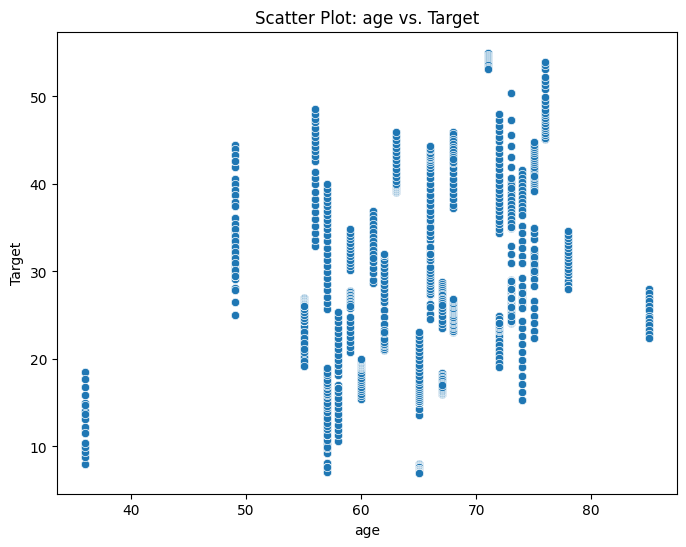

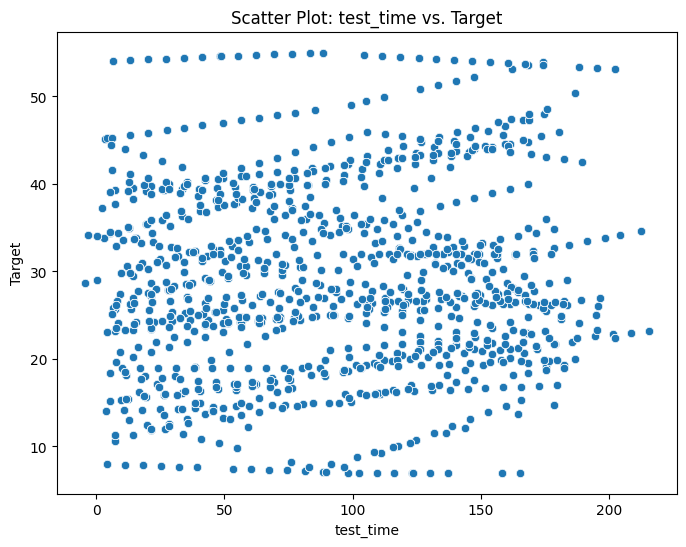

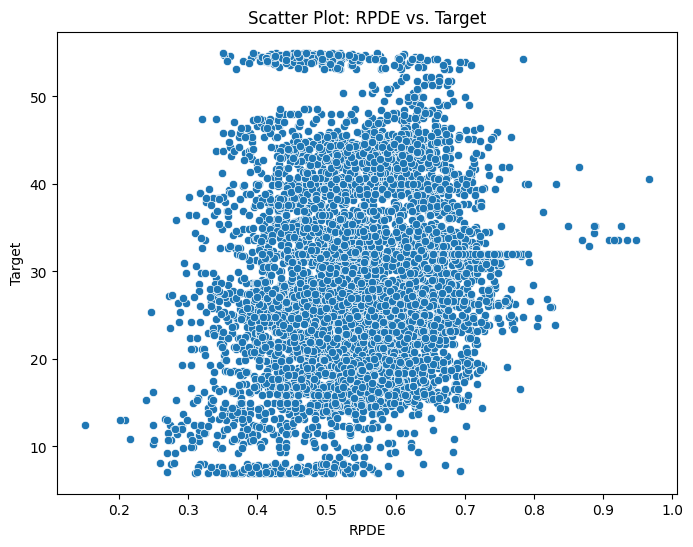

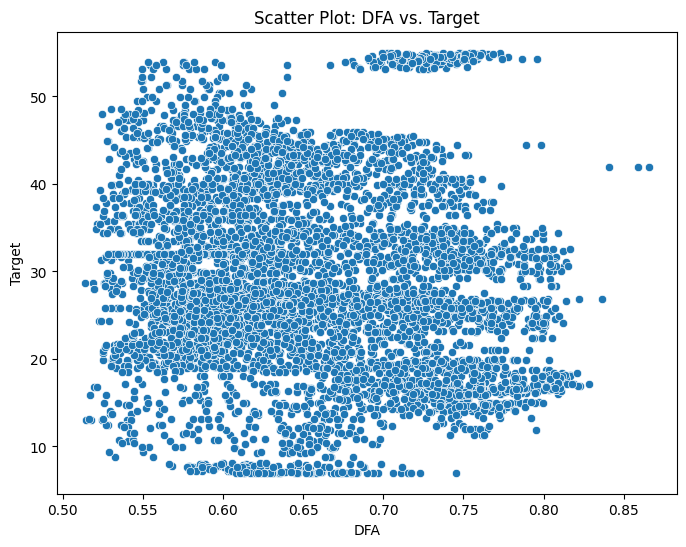

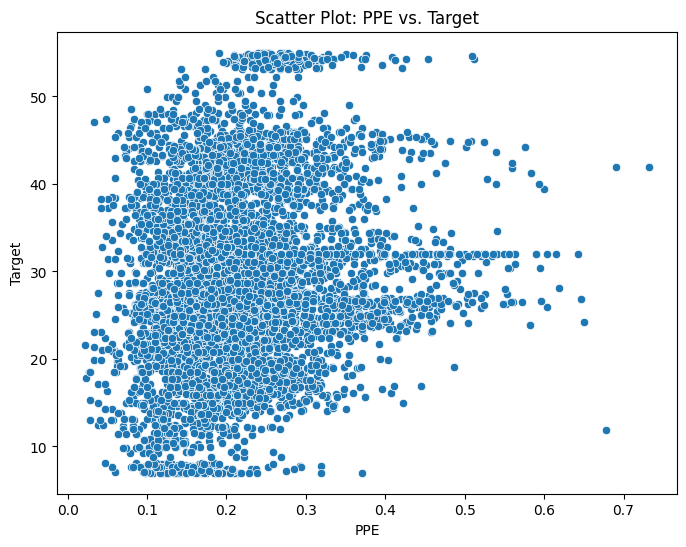

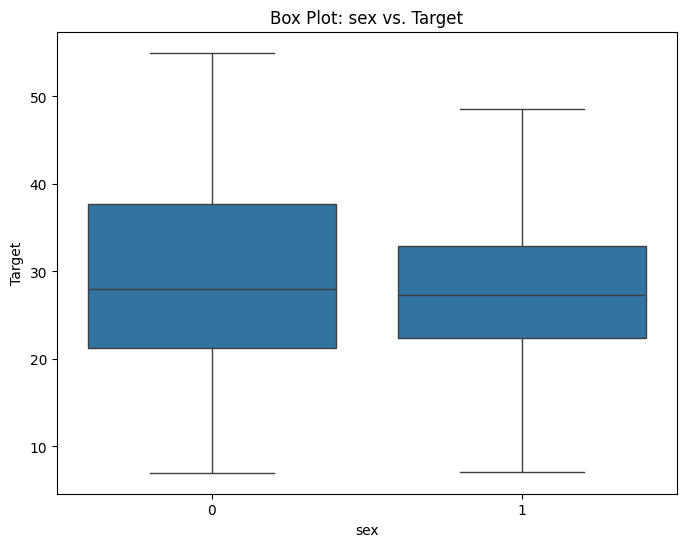

In [61]:
# Add the target variable back to the reduced dataset for visualization
df_reduced = X_reduced.copy()
df_reduced['target'] = y

# Scatter plots for numerical features vs. target
numerical_features = X_reduced.select_dtypes(include=['number']).columns

for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df_reduced[feature], y=df_reduced['target'])
    plt.title(f'Scatter Plot: {feature} vs. Target')
    plt.xlabel(feature)
    plt.ylabel('Target')
    plt.show()

# Box plots for categorical features vs. target
categorical_features = X_reduced.select_dtypes(include=['category', 'object']).columns

# for sex, 0 is male, 1 is female
for feature in categorical_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df_reduced[feature], y=df_reduced['target'])
    plt.title(f'Box Plot: {feature} vs. Target')
    plt.xlabel(feature)
    plt.ylabel('Target')
    plt.show()

## Perform Analysis Using Supervised Machine Learning Models

I'm going to start with a simple linear regression model to gauge how complex the data is. I am suspicious that it won't be worth while because the relationships between medical evaluations are complex and I've already determined there are outliers in the dataset.


In [62]:
# Separate features and target
X = df_reduced.drop('target', axis=1)
y = df_reduced['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Print the regression coefficients
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coefficients)

Mean Squared Error: 94.74477776653505
R-squared: 0.14500337751625703
           Coefficient
age           0.325000
test_time     0.014810
RPDE          8.574534
DFA         -27.637821
PPE          16.503758
sex          -1.830949


The simple linear regression model performed very poorly with an R-square of 0.14. The feature set seems complex, so next I'm going to try a gradient boosted regressor. The medical features are likely still interacting with eachother; the tree-based structure of a gradient boost would consider interactions between features where linear regression does not. 

In [63]:
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the regressor on the training data
gbr.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = gbr.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Print feature importances
feature_importances = pd.DataFrame(gbr.feature_importances_, X.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)
print(feature_importances)

Mean Squared Error: 23.74296906678614
R-squared: 0.7857384983279956
           Importance
age          0.823766
DFA          0.074700
sex          0.041778
test_time    0.027827
RPDE         0.020051
PPE          0.011878


The gradient boosting regressor performed a lot better than the linear regression model. The features are all pretty high in importance. Considering that the point of the analysis is to save people time with testing, it would be ideal to minimize the features. However, DFA is still one of the important features, so I don't think at the end of the day that it would help people to reduce the features any further. Instead I'll try performing a grid search to optimize the parameters of the model.

In [64]:
# Create parameter grid for searching
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_leaf': [1, 2, 4],
}

# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, scoring='r2', cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best parameters
print(f"Best parameters found: {best_params}")

# Make predictions on the testing data
y_pred = best_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 200}
Mean Squared Error: 4.569571912057361
R-squared: 0.9587632306169638


The R-squared value is great! I don't think it needs any further tweaking, so lets plot the results.

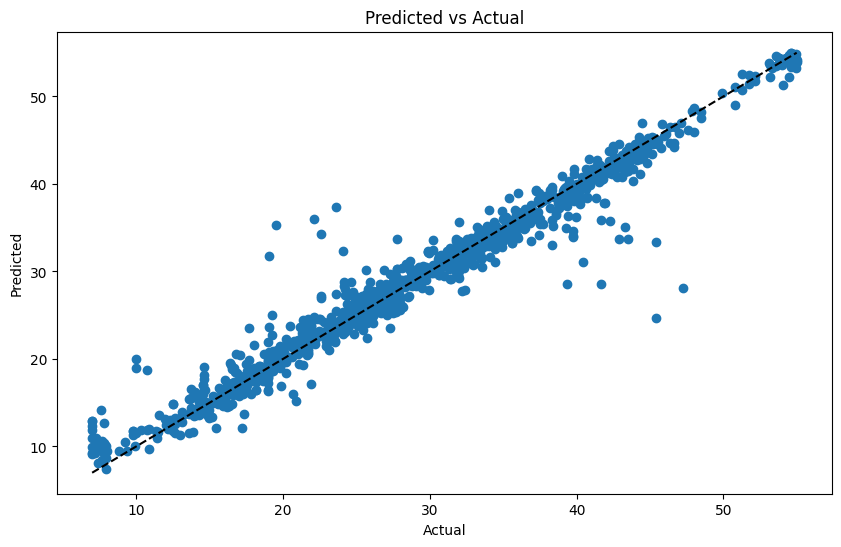

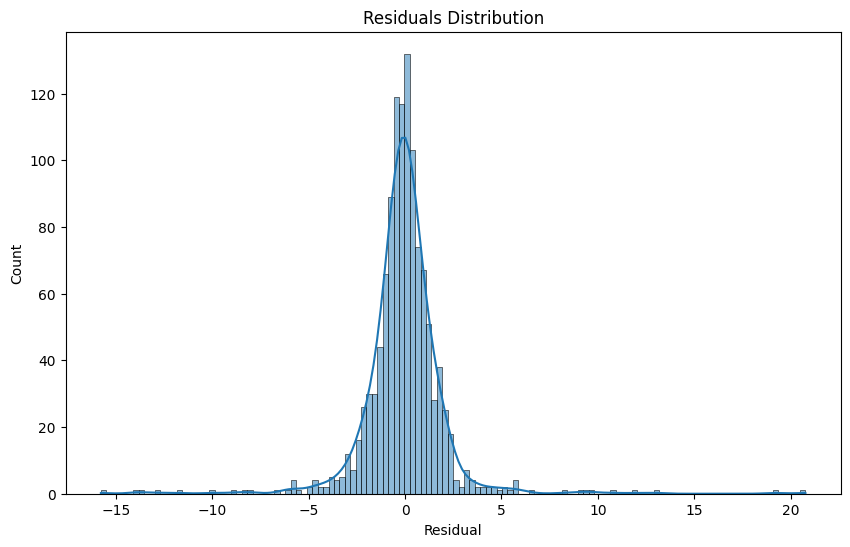

In [65]:
# Plot the results

# Plot predicted vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.show()

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residual')
plt.title('Residuals Distribution')
plt.show()


## Conclusion
We ended up with a gradient boosted regression model that uses age, DFA, sex, test_time, RPDE, and PPE to predict a value for total_UPDRS. The model isn't perfect, but with a R2 value of 0.96, it's reasonable. The residuals are not completely symmetrical; At low scores it tends to overpredict and at high scores it underpredicts. I don't exactly know the consequence of the score values, so a clinician would need to evaluate this for acceptability. Regardless, this is likely great news for patients and clinicians trying to get a unified Parkinson's disease rating scale score, because it means that they can use a non-invasive audio test; saving time and money. I don't think that it could completely replace in-office exams, but it certainly has merit as a low-cost alternative.